In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [11]:
#Finding the max date
max_date = session.query(func.max(func.strftime("%Y-%m-%d", Measurement.date))).limit(5).all()
max_date[0][0]

'2017-08-23'

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores

precipitation_data = session.query(func.strftime("%Y-%m-%d", Measurement.date), Measurement.prcp).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >=dt.date(2016,8,23)).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(precipitation_data, columns= ["date", "precipitation"]).sort_values(by="date")

# Set Index
precipitation_df.set_index("date", inplace=True)
precipitation_df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


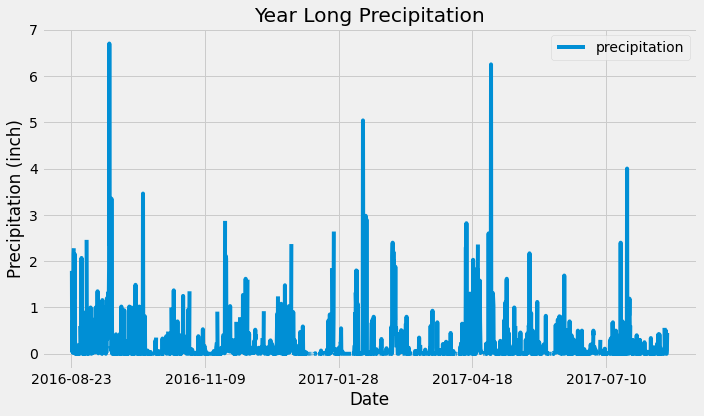

In [37]:
# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(figsize= (10,6))
precipitation_df.plot(ax = ax)
ax.set_xlabel("Date")
ax.set_ylabel("Precipitation (inch)")
ax.set_title("Year Long Precipitation")
plt.legend(loc="best")
plt.savefig("Precipitation.png")
plt.tight_layout()
plt.show()

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
round(precipitation_df.describe(),2)

,precipitation
count,2021.00
mean,0.18
std,0.46
min,0.00
25%,0.00
50%,0.02
75%,0.13
max,6.70


In [15]:
# Design a query to show how many stations are available in this dataset?
stations= session.query(Station.id).distinct().count()
stations

9

In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_count = (session.query(Measurement.station, func.count(Measurement.station))
                .group_by(Measurement.station).order_by(func.count(Measurement.station)
                .desc()).all())
station_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_station= "USC00519281"
temperature = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
            filter(Measurement.station == most_active_station).all()
temperature

[(54.0, 85.0, 71.66378066378067)]

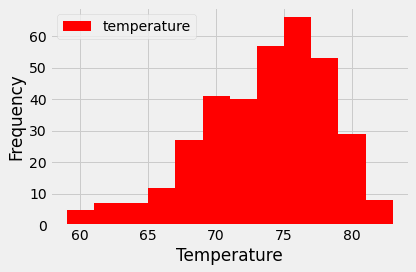

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_obs = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == most_active_station).\
                filter(func.strftime("%Y-%m-%d", Measurement.date) >= dt.date( 2016, 8, 23)).all()

temperature_obs_df = pd.DataFrame(temperature_obs, columns= ["date", "temperature"])

fig, ax = plt.subplots()
temperature_obs_df.plot.hist(bins = 12, ax = ax, color= "red")
ax.set_xlabel("Temperature")
ax.set_ylabel("Frequency")
plt.legend(loc="best")
plt.savefig("Temperature plot for one year.png")
plt.tight_layout()
plt.show()

## Bonus Challenge Assignment

### Temperature Analysis

In [47]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2016-04-15', '2016-04-23'))

[(66.0, 73.26315789473684, 80.0)]


In [45]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_data = calc_temps("2016-04-15", "2016-04-23")
trip_data

[(66.0, 73.26315789473684, 80.0)]

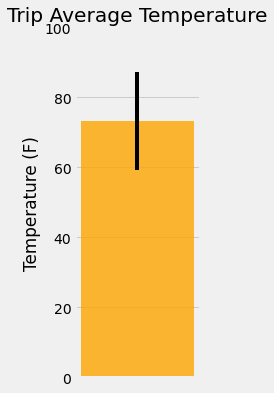

In [46]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
min_temp = trip_data[0][0]
avg_temp = trip_data[0][1]
max_temp = trip_data[0][2]

min_error = avg_temp - min_temp
max_error = max_temp - avg_temp

plt.figure(figsize=(2,6))
plt.bar(0, avg_temp, yerr=[max_temp-min_temp], color = 'orange', alpha=0.8)
plt.title('Trip Average Temperature')
plt.ylim(0,100)
plt.ylabel('Temperature (F)')
plt.xticks([])
plt.savefig("Trip Average Temperature.png")
plt.show()

### Daily Rainfall Average

In [28]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start_date = '2017-04-15'
end_date = '2017-04-23'

total_rainfall = session.query(Station.station,func.sum(Measurement.prcp),
                  Station.name,Station.elevation,Station.latitude,
                  Station.longitude)\
                  .filter(Measurement.station == Station.station)\
                  .filter(Measurement.date >= start_date)\
                  .filter(Measurement.date <= end_date)\
                  .group_by(Station.station)\
                  .order_by(func.sum(Measurement.prcp).desc())

for row in total_rainfall :
    rain="{0:.2f}".format(row[1])
    print (f"Station:  {row[0]}\n    Rainfall:  {row}  \n    Location:  {row[2]}\n    Elevation:  {row[3]}  \
    Latitude:  {row[4]}  Longitude:  {row[5]}")
    print()


Station:  USC00519281
    Rainfall:  ('USC00519281', 7.369999999999999, 'WAIHEE 837.5, HI US', 32.9, 21.45167, -157.84888999999998)  
    Location:  WAIHEE 837.5, HI US
    Elevation:  32.9      Latitude:  21.45167  Longitude:  -157.84888999999998

Station:  USC00516128
    Rainfall:  ('USC00516128', 6.970000000000001, 'MANOA LYON ARBO 785.2, HI US', 152.4, 21.3331, -157.8025)  
    Location:  MANOA LYON ARBO 785.2, HI US
    Elevation:  152.4      Latitude:  21.3331  Longitude:  -157.8025

Station:  USC00513117
    Rainfall:  ('USC00513117', 3.97, 'KANEOHE 838.1, HI US', 14.6, 21.4234, -157.8015)  
    Location:  KANEOHE 838.1, HI US
    Elevation:  14.6      Latitude:  21.4234  Longitude:  -157.8015

Station:  USC00519523
    Rainfall:  ('USC00519523', 3.1599999999999997, 'WAIMANALO EXPERIMENTAL FARM, HI US', 19.5, 21.33556, -157.71139)  
    Location:  WAIMANALO EXPERIMENTAL FARM, HI US
    Elevation:  19.5      Latitude:  21.33556  Longitude:  -157.71139

Station:  USC00514830
    

In [29]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [42]:
#create a function called daily_normals that will calculate the daily normals for a specific date
def daily_normals(day_date):
    temperature = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
                          filter(func.strftime("%m-%d", Measurement.date) == day_date).all()
    return temperature
# Set the start and end date of the trip
trip_start = dt.date(2017,4,15)
trip_end = dt.date(2017,4,23)
# Use the start and end date to create a range of dates
trip_dates = pd.date_range(trip_start, trip_end)
# Stip off the year and save a list of %m-%d strings
trip_formatting = trip_dates.strftime('%m-%d')
# Loop through the list of %m-%d strings and calculate the normals for each date
normals_list = []
for trip_date in trip_formatting:
    #unpack daily_normals
    normals_list.append(*daily_normals(trip_date))

In [43]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df = pd.DataFrame(normals_list, columns = ['Tmin', 'Tavg', 'Tmax'])

#Set trip dates as index
df['Date'] = trip_dates
df = df.set_index('Date')

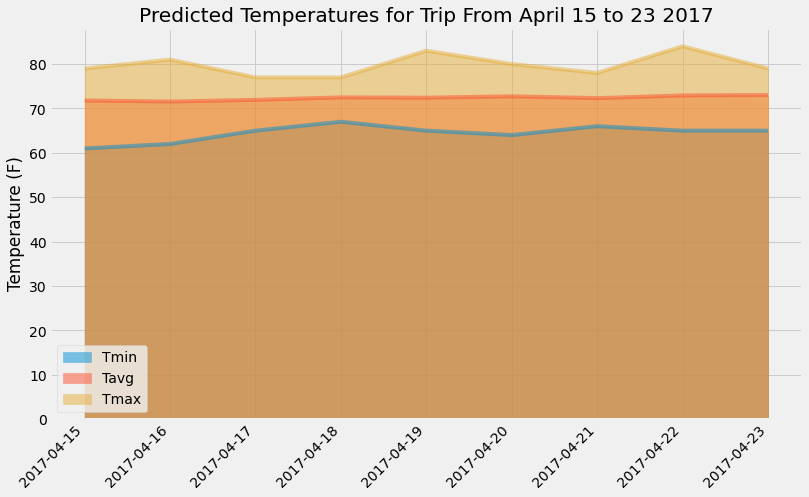

In [44]:
# Plot the daily normals as an area plot with `stacked=False`
colors = ['blue', 'pink', 'orange']

#make an area plot for the predicted temps
df.plot(kind='area', figsize=(12, 8), stacked=False, x_compat=True, title='Predicted Temperatures for Trip From April 15 to 23 2017', rot=45)

#make the labels
plt.xlabel('')
plt.ylabel('Temperature (F)')
plt.savefig("Predicted Temperatures for trip.png")
plt.show()